# Building the UI
In addition to the Neo4j console and the notebook earlier, we can provide develop a public facing website that we can share with the public without providing them write access to the neo4j database.

The UI provides single and two-term search where the latter uses allShortestPath to query all the shortest paths between two terms. To build the UI, we need to create a UI schema that is built using the data that was ingested in the graph db. This notebook automates the creation of this schema file.

In [1]:
import re
import json
from glob import glob
import pandas as pd
import glasbey
import seaborn as sns

sns.set()

In [2]:
counter = 0
for filename in glob("../out/0915/filtered/nodes/*.nodes.csv"):
    counter += 1
counter

115

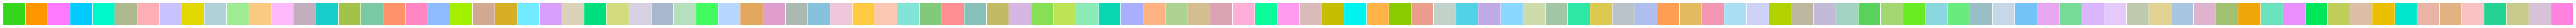

In [3]:
palette = glasbey.create_palette(palette_size=counter, lightness_bounds=(65, 80))
sns.palplot(palette)

In [4]:
palette[0]

'#35d71c'

## Node Schema

```
{
    "node": "Gene",
    "example": [
        "COPB2",
        "SDF2L1"
    ],
    "display": [
        {
            "label": "Gene ID",
            "text": "${id}",
            "type": "text"
        },
        {
            "label": "label",
            "text": "${label}",
            "type": "text"
        },
        {
            "label": "uri",
            "text": "${uri}",
            "href": "${uri}",
            "type": "link"
        }
    ],
    "search": [
        "id",
        "label"
    ],
    "color": "#c5e1a5"
}

```
This is a node schema for the node "Gene". The example field will display as an example on the UI while the display field tells the UI what to display as a tooltip. Meanwhile, search tells the UI that we can search both id and label fields of the nodes. Node colors are automatically generated but can otherwise be set using the field color for more customization.

In [14]:
node_schema = []
node_pattern = "(?P<directory>.+)/(?P<label>.+)\.(?P<entity>.+)\.csv"
counter = 0
for filename in glob("../out/0915/filtered/nodes/*.nodes.csv"):
    match = re.match(node_pattern, filename).groupdict()
    label = match["label"].replace("_", " ")
    df = pd.read_csv(filename, low_memory=False)
    display = []
    search = []
    for i in df.columns:
        if i == "id":
            display.append({
                'label': '%s ID'%label,
                'text': "${%s}"%i,
                'type': 'text'
            })
        else:
            val = str(df.at[0, i])
            if val.startswith("http"):
                display.append({
                    'label': i,
                    'text': "${%s}"%i,
                    'href': "${%s}"%i,
                    'type': 'link'
                })
            else:
                display.append({
                    'label': i,
                    'text': "${%s}"%i,
                    'type': 'text'
                })
    examples = [i for i in df["label"].unique() if type(i) == str][0:2]
    node = {
        "node": label,
        "example": examples,
        "display": display,
        "relation": [],
        "search": [i for i in df.columns if "value" not in i and "lowerbound" not in i and "upperbound" not in i ],
        "color": palette[counter]
    }
    counter += 1
    node_schema.append(node)
        

## Edge Schema
```
{
    "match": [
        "KEGG"
    ],
    "selected": true,
    "display": [
        {
            "label": "source",
            "text": "${source}",
            "type": "text"
        },
        {
            "label": "relation",
            "text": "${relation}",
            "type": "text"
        },
        {
            "label": "target",
            "text": "${target}",
            "type": "text"
        },
        {
            "label": "source label",
            "text": "${source_label}",
            "type": "text"
        },
        {
            "label": "target label",
            "text": "${target_label}",
            "type": "text"
        },
        {
            "label": "resource",
            "text": "${resource}",
            "href": "${resource}",
            "type": "link"
        }
    ]
}
```

This is the same with node schema with a few differences, first match allows you to match multiple edge types and selected is a field that allows us to select what edges are queried by default when doing two term searches.

In [15]:
edge_schema = []
edge_pattern = "(?P<directory>.+)/(?P<source_type>.+)\.(?P<relation>.+)\.(?P<target_type>.+)\.(?P<entity>.+)\.csv"
edge_dict = {}
for filename in glob("../out/0915/filtered/edges/*.edges.csv"):
   match = re.match(edge_pattern, filename).groupdict()
   entity = match["entity"]
   source_type = match["source_type"]
   relation = match["relation"].replace("_", " ")
   edge = {
      # "match": [relation],
      "selected": True,
   }
   order = ["evidence", "ASC"] if "negative" in relation.lower() else ["evidence", "DESC"]
   color = "#bdbdbd"
   if "positive" in relation.lower():
       color = "#90caf9" 
   elif "negative" in relation.lower():
      color = "#ef9a9a"
   edge["order"] = order
   edge["color"] = color
   df = pd.read_csv(filename)
   display = []
   for i in df.columns:
      if "label" not in i:
         if i == "id":
            display.append({
                  'label': '%s ID'%label,
                  'text': "${%s}"%i,
                  'type': 'text'
            })
         else:
            val = str(df.at[0, i])
            if val.startswith("http"):
                  display.append({
                     'label': i.replace("_", " "),
                     'text': "${%s}"%i,
                     'href': "${%s}"%i,
                     'type': 'link'
                  })
            else:
                  display.append({
                     'label': i.replace("_", " "),
                     'text': "${%s}"%i,
                     'type': 'text'
                  })
            edge["display"] = display
   edge_cols = ",".join(list(df.columns) + order + [color])
   if edge_cols not in edge_dict:
       edge_dict[edge_cols] = {
           "match": [relation],
           **edge
       }
   else:
       edge_dict[edge_cols]["match"].append(relation)

edge_schema = list(edge_dict.values())
len(edge_schema)
         

3

In [16]:
edge_dict[edge_cols]

{'match': ['produces',
  'associated with',
  'expressed in',
  'indication',
  'regulates',
  'produces',
  'produces',
  'expresses',
  'causally influenced by',
  'correlated with condition',
  'produced by',
  'produces',
  'expressed in',
  'produced by',
  'involved in',
  'isa',
  'indication',
  'gene associated with disease or phenotype',
  'produced by',
  'phenotype of',
  'causally influences',
  'has part',
  'indication',
  'molecularly interacts with',
  'produces',
  'correlated with condition',
  'associated with',
  'causally influences',
  'located in',
  'produces',
  'produced by',
  'correlated with condition',
  'gene associated with disease or phenotype',
  'overlaps',
  'coexpression Pancreas',
  'is subsequence of',
  'is approximately equivalent to',
  'is approximately equivalent to',
  'produced by',
  'produced by',
  'correlated with condition',
  'produced by',
  'produced by',
  'signature gene of',
  'synthesized by',
  'indication',
  'associated with

## Additional schema

The next part are miscellaneous schemas that you can use to modify our UI. Notice the tabs field, this is where we define the pages in our knowledge graph as well as the components that you want to render.

Currently we have the following components available:
1. KnowledgeGraph: this renders the single and two term search components
2. Markdown: this is for rendering static markdown files, useful for tutorials
3. Enrichment: For enrichment page.
   
Each component takes specific props like init_function that initializes/prefetch the static props for the page. For this example, we only look at the KnowledgeGraph component. For more information on how to use the other components you can check: https://maayanlab.cloud/enrichr-kg/api/knowledge_graph/schema

In [17]:
rest = {
    "header": {
		"title": "Data Distillery Knowledge Graph",
		"icon": {
			"src": "https://s3.amazonaws.com/maayan-kg/cfde-kg/assets/CFDE.png",
			"favicon": "https://s3.amazonaws.com/maayan-kg/cfde-kg/assets/favicon.png",
			"faviconTitle": "Data Distillery KG",
			"alt": "Data Distillery",
			"key": "data_distillery_logo",
			"width": 100,
			"height": 100
		},
		"tabs": [
			{
				"endpoint": "/",
				"label": "Term & Gene Search",
				"type": "page",
				"component": "KnowledgeGraph",
				"props": {
					"init_function": "initialize_kg",
                    "initial_query": {
                        "start": "Gene or Genome",
                        "start_term": "CES1 gene",
                        "start_field": "label", 
                        "relation": "positively regulated by"
					}
				}
			}
		]
	},
	"footer": [
		{
			"type": "github",
			"code": "https://github.com/MaayanLab/enrichr-kg",
			"issues": "https://github.com/MaayanLab/enrichr-kg/issues"
		},
		{
			"type": "icon",
			"key": "lab_icon",
			"src": "https://minio.dev.maayanlab.cloud/enrichr-kg/maayan-lab.jpg",
			"alt": "MaayanLab",
			"href": "https://labs.icahn.mssm.edu/maayanlab/",
			"height": 125,
			"width": 150
		},
		{
			"type": "icon",
			"key": "center_icon",
			"src": "https://minio.dev.maayanlab.cloud/enrichr-kg/ISMMS_Center_Bioinformatics_RGB_Vrtl.jpg",
			"alt": "COB",
			"href": "https://icahn.mssm.edu/research/bioinformatics",
			"height": 125,
			"width": 200
		}

	]
}

## Putting it all together

In [18]:
schema = {
    "nodes": node_schema,
    "edges": edge_schema,
    **rest
}

with open("../schema.json", 'w') as o:
    o.write(json.dumps(schema, indent=4))

Once you have the schema, you can upload it and obtain a link, then set the following as env variable:

```
## landing endpoint
NEXT_PUBLIC_PREFIX=

## NEO4 specs
NEO4J_URL=bolt://localhost:7687
NEO4J_USER=neo4j
NEO4J_NAME=kg
NEO4J_PASSWORD=mysecretpassword

# The link to the schema
NEXT_PUBLIC_SCHEMA=https://s3.amazonaws.com/maayan-kg/enrichr-kg/assets/schema.json

# set this if you are using assets (images etc) from different domains
NEXT_PUBLIC_DOMAINS=minio.dokku.maayanlab.cloud,github.com,minio.dev.maayanlab.cloud,s3.amazonaws.com


NEXT_PUBLIC_HOST=http://localhost:3000

```

Then run the following:

```
docker-compose up
```

http://localhost:3000/ should now be accessible (provided you kept the same prefix as above, if you set it to say, /kg, the the site is accessible on http://localhost:3000/kg)
